# Experimental: Self-Supervised Learning

Our goal will be to teach a neural network to learn how to solve an airfoil optimization problem. 

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from scipy.stats import qmc
import jenn
from jenn.core.cost import Loss

In [3]:
SEED = 123

## Parabolic Test Function

_First, we will test that the process is working for a parabolic test function._

### Training Data

In [4]:
m = 100
lb = -5
ub = 5
x_train = x1 = np.linspace(lb, ub, m).reshape((1, -1)) 
x2 = -1/2 * x1  # optimum given x1
y_train = x1 ** 2 + x2 ** 2 + x1 * x2

### Custom Loss

In [5]:
class CustomLoss(Loss): 
    """Parabola."""

    def denormalize(self, Y_pred: np.ndarray) -> np.ndarray:
        x_norm = self.X 
        y_norm = Y_pred 
        x_ref = self.data.x_ref
        y_ref = self.data.y_ref
        x_scale = self.data.x_scale
        y_scale = self.data.y_scale
        x = x_ref + x_norm * x_scale
        y = y_ref + y_norm * y_scale 
        return x, y
        
    def evaluate(self, Y_pred: np.ndarray) -> np.ndarray:
        x, y = self.denormalize(Y_pred)
        return x ** 2 + y ** 2 + x * y

    def evaluate_partials(self, Y_pred: np.ndarray) -> np.ndarray:
        """Compute partials for each airfoil shape."""
        x, y = self.denormalize(Y_pred)
        return 2 * y + x

### Training

Training can be done in one line of code. 

In [26]:
%%time
nn = jenn.model.NeuralNet(
    layer_sizes=[x_train.shape[0], 7, 7, y_train.shape[0]],
).fit(
    x=x_train, 
    y=y_train, 
    alpha=1e-3,
    lambd=1e-4, 
    beta1=0.8,
    beta2=0.7,
    max_iter=500,
    is_normalize=False,
    is_verbose=True, 
    random_state=SEED, 
    custom_loss=CustomLoss
)

epoch = 0, batch = 0, iter = 0, cost =  7.315
epoch = 0, batch = 0, iter = 1, cost =  7.298
epoch = 0, batch = 0, iter = 2, cost =  7.281
epoch = 0, batch = 0, iter = 3, cost =  7.265
epoch = 0, batch = 0, iter = 4, cost =  7.248
epoch = 0, batch = 0, iter = 5, cost =  7.232
epoch = 0, batch = 0, iter = 6, cost =  7.216
epoch = 0, batch = 0, iter = 7, cost =  7.200
epoch = 0, batch = 0, iter = 8, cost =  7.184
epoch = 0, batch = 0, iter = 9, cost =  7.169
epoch = 0, batch = 0, iter = 10, cost =  7.154
epoch = 0, batch = 0, iter = 11, cost =  7.139
epoch = 0, batch = 0, iter = 12, cost =  7.124
epoch = 0, batch = 0, iter = 13, cost =  7.109
epoch = 0, batch = 0, iter = 14, cost =  7.095
epoch = 0, batch = 0, iter = 15, cost =  7.081
epoch = 0, batch = 0, iter = 16, cost =  7.067
epoch = 0, batch = 0, iter = 17, cost =  7.053
epoch = 0, batch = 0, iter = 18, cost =  7.039
epoch = 0, batch = 0, iter = 19, cost =  7.026
epoch = 0, batch = 0, iter = 20, cost =  7.013
epoch = 0, batch = 0, i

### Visualization

#### Convergence Histories

It is good practice to check the convergence history in order to decide if we should keep training.

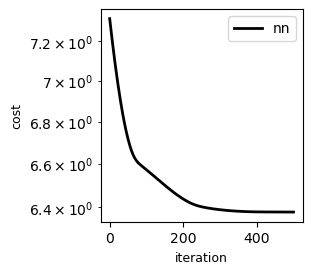

In [27]:
jenn.utils.plot.convergence(histories=[nn.history], legend=["nn"])

#### Goodness of Fit

_Goodness of fit is perfect, implying that SSL is working (at least for an easy test function)._

In [28]:
x1 = x_train
x2 = nn.predict(x_train) 
y_pred = x1 ** 2 + x2 ** 2 + x1 * x2

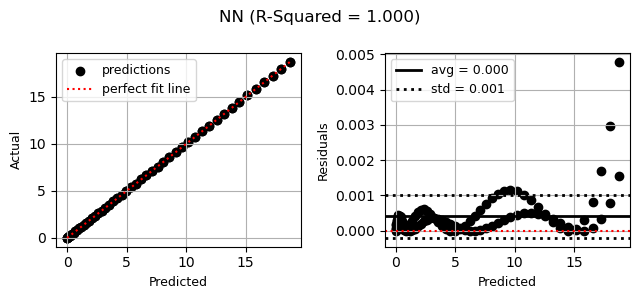

In [29]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_train, 
    y_pred=y_pred,
    title="NN"
)

## Airfoil Shape Optimization 

We now test SSL on a small yet representative airfoil shape optimization problem. Given some desired flight condition, we seek to use SSL in order to predict the optimal airfoil shape. 

### Training Data

In [34]:
df = pd.read_csv("DATABASE_OF_OPTIMIZED_SHAPEVARS.csv", index_col=0)
df

,M,CL,CD,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13
0,0.70,-3.321652e-07,0.000256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.70,1.249999e-01,0.000312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.70,2.500004e-01,0.000538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.70,3.749999e-01,0.001820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.70,4.999999e-01,0.001317,0.000176,-0.000838,-0.000492,-0.000755,-0.001098,-0.000937,-0.003238,-0.001843,-0.003421,0.004054,0.006216,0.002951,0.001618,0.002667
5,0.75,-2.907438e-08,0.000357,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.75,1.249998e-01,0.000959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.75,2.500003e-01,0.003728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.75,3.750000e-01,0.001161,0.000616,-0.001395,-0.001429,-0.000675,-0.001133,-0.001641,-0.003411,-0.001069,-0.005489,0.001069,0.005774,0.004581,0.001844,0.002222
9,0.75,4.999998e-01,0.001873,0.000078,-0.001470,-0.001426,-0.001023,-0.001342,-0.001811,-0.003390,-0.001910,-0.006040,0.000845,0.006259,0.005551,0.002371,0.002561


In [35]:
x_labels = ["M", "CL"]
y_labels = [f"X{i}" for i in range(14)]

In [36]:
x_test = df[x_labels].values.T
y_test = df[y_labels].values.T

In [37]:
def fullfact2(levels=(10, 10)): 
    """Generate full factorial for two variables."""
    x1 = np.linspace(0, 1, levels[0])
    x2 = np.linspace(0, 1, levels[1])
    return np.array([[x1[i], x2[j]] for i in range(levels[0]) for j in range(levels[1])])

In [207]:
latin_hypercube = False 

# sample x 
lb = x_test.min(axis=1, keepdims=True)
ub = x_test.max(axis=1, keepdims=True)
# lb = np.array([[0.75], [0.1]]) 
# ub = np.array([[0.85], [0.4]]) 
sample = qmc.LatinHypercube(d=2).random(25) if latin_hypercube else fullfact2(levels=(5, 5))
x_train = lb + (ub - lb) * sample.T
    
# Sample y 
sampler = qmc.LatinHypercube(d=14)
sample = sampler.random(sample.shape[0])
lb = y_test.min(axis=1, keepdims=True)
ub = y_test.max(axis=1, keepdims=True)
y_train = lb + (ub - lb) * sample.T

### Custom Loss

_We'll use a surrogate of the model for illustration but, in practice, one would use the actual CFD model._

In [208]:
CFD_MODEL = jenn.model.NeuralNet(
    layer_sizes=[16, [16] * 5, 1]
).load('gnn_parameters.json') 

In [209]:
class CFDLoss(Loss): 
    """Minimize drag."""

    def denormalize(self, Y_pred: np.ndarray) -> np.ndarray:
        x_norm = self.X  # flight conditions 
        y_norm = Y_pred  # shape variables
        x_ref = self.data.x_ref
        y_ref = self.data.y_ref
        x_scale = self.data.x_scale
        y_scale = self.data.y_scale
        x = x_ref + x_norm * x_scale
        y = y_ref + y_norm * y_scale 
        return x, y

    def _evaluate_penalty(self, y: np.ndarray, lb: float = -0.01, ub: float = 0.01, r_p: float = 1e9): 
        upper_bound = np.maximum(0, (y - ub) / (ub - lb)) ** 2
        lower_bound = np.minimum(0, (y - lb) / (ub - lb)) ** 2
        value = r_p * (lower_bound + upper_bound)
        upper_bound_partials = 2 * np.maximum(0, (y - ub) / (ub - lb)) / (ub - lb)
        lower_bound_partials = 2 * np.minimum(0, (y - lb) / (ub - lb)) / (ub - lb)
        partials = r_p * (lower_bound_partials + upper_bound_partials)
        return value, partials

    def evaluate(self, Y_pred: np.ndarray) -> np.ndarray:
        """Compute drag for each airfoil shape."""
        x, y = self.denormalize(Y_pred)
        drag = CFD_MODEL.predict(np.concatenate([x, y], axis=0))
        penalty = self._evaluate_penalty(y)[0] 
        return drag + penalty
    
    def evaluate_partials(self, Y_pred: np.ndarray) -> np.ndarray:
        """Compute partials for each airfoil shape."""
        x, y = self.denormalize(Y_pred)
        drag, drag_partials = CFD_MODEL.evaluate(np.concatenate([x, y], axis=0))
        penalty_partials = self._evaluate_penalty(y)[1] 
        return drag_partials[:, 2:, :] + penalty_partials

In [210]:
%%time
nn = jenn.model.NeuralNet(
    layer_sizes=[x_train.shape[0]] + [5] + [y_train.shape[0]],
).fit(
    x=x_train, 
    y=y_train, 
    alpha=1e-3,
    lambd=0, 
    beta1=0.9,
    beta2=0.99,
    max_count=4,
    max_iter=1_000,
    # batch_size=25,
    # epochs=100,
    is_normalize=True,  
    is_backtracking=True, 
    is_verbose=True, 
    random_state=SEED, 
    custom_loss=CFDLoss, 
)

epoch = 0, batch = 0, iter = 0, cost =  0.365
epoch = 0, batch = 0, iter = 1, cost =  0.364
epoch = 0, batch = 0, iter = 2, cost =  0.363
epoch = 0, batch = 0, iter = 3, cost =  0.363
epoch = 0, batch = 0, iter = 4, cost =  0.362
epoch = 0, batch = 0, iter = 5, cost =  0.361
epoch = 0, batch = 0, iter = 6, cost =  0.361
epoch = 0, batch = 0, iter = 7, cost =  0.360
epoch = 0, batch = 0, iter = 8, cost =  0.359
epoch = 0, batch = 0, iter = 9, cost =  0.359
epoch = 0, batch = 0, iter = 10, cost =  0.358
epoch = 0, batch = 0, iter = 11, cost =  0.357
epoch = 0, batch = 0, iter = 12, cost =  0.357
epoch = 0, batch = 0, iter = 13, cost =  0.356
epoch = 0, batch = 0, iter = 14, cost =  0.355
epoch = 0, batch = 0, iter = 15, cost =  0.355
epoch = 0, batch = 0, iter = 16, cost =  0.354
epoch = 0, batch = 0, iter = 17, cost =  0.353
epoch = 0, batch = 0, iter = 18, cost =  0.353
epoch = 0, batch = 0, iter = 19, cost =  0.352
epoch = 0, batch = 0, iter = 20, cost =  0.351
epoch = 0, batch = 0, i

### Visualization

#### Convergence Histories

It is good practice to check the convergence history in order to decide if we should keep training.

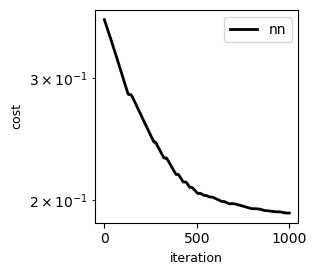

In [211]:
jenn.utils.plot.convergence(histories=[nn.history], legend=["nn"])

#### Goodness of Fit

_Goodness of fit is perfect, implying that SSL is working (at least for an easy test function)._

In [212]:
def call_cfd(flight_condition: np.ndarray, optimal_airfoil: np.ndarray = None): 
    if optimal_airfoil is None: 
        optimal_airfoil = nn.predict(flight_condition)
    x = np.concatenate([flight_condition, optimal_airfoil], axis=0)
    drag = CFD_MODEL.predict(x)
    return drag

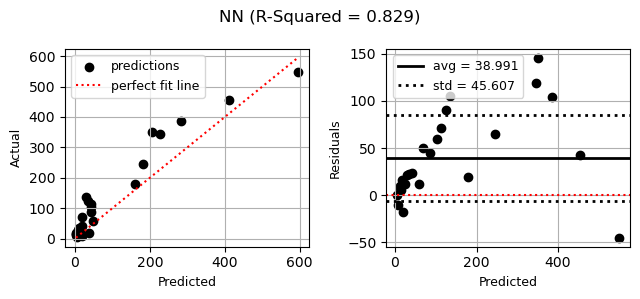

In [213]:
jenn.utils.plot.goodness_of_fit(
    y_true=1e4 * df["CD"].values.reshape((1, -1)), 
    y_pred=1e4 * call_cfd(x_test),
    title="NN", 
    percent_residuals=False
)

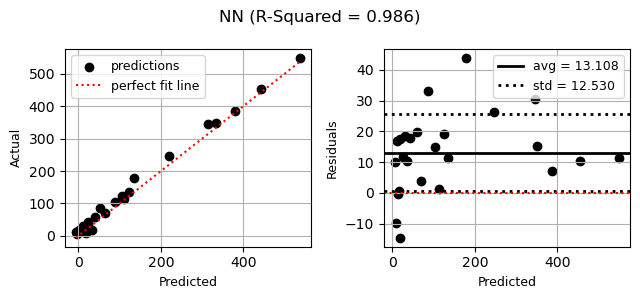

In [214]:
jenn.utils.plot.goodness_of_fit(
    # y_true=1e4 * df["CD"].values.reshape((1, -1)),   
    y_true=1e4 * call_cfd(x_test, y_test), 
    y_pred=1e4 * call_cfd(x_test),
    title="NN", 
    percent_residuals=False
)

In [216]:
M = 0.85
CL = 0.5
nn.predict(np.array([[M], [CL]]))

array([[-0.00886051],
       [-0.00901268],
       [-0.00689078],
       [-0.00741607],
       [-0.00403035],
       [ 0.00044704],
       [-0.00882154],
       [-0.00697353],
       [-0.00888725],
       [-0.00841705],
       [-0.00852379],
       [-0.00402988],
       [ 0.00978394],
       [ 0.0087298 ]])